# COMP90051 Workshop 11
## Bayesian Regression
***
In this workshop we'll look at Bayesian regression. Briefly, this involves learning a linear regression model from a training set of $(\mathbf{x}, y)$ pairs, where $\mathbf{x}$ is a feature vector and $y$ is a real-valued response variable. Earlier we looked at ridge regression, which involved:
1. assuming a linear relationship between inputs and outputs, i.e., $y \approx \mathbf{w} \cdot \mathbf{x}$ for all pairs
2. minimising the *residual sum of squares error*, that is finding the parameters $\hat{\mathbf{w}}$ that give the best fit to the training responses (with a regularisation term that penalises large weights) 
3. using $\hat{\mathbf{w}}$ to make test inferences

We'll now look at *Bayesian* inference for the above model. 
In this case we don't follow steps 2 and 3 above, but rather formulate the *posterior* over the weights, and make test inferences using *all settings of the weights* according to their posterior probability. 
These operations can be solved exactly, using linear algebra.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.random.seed(1)

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import BayesianRidge

### 1. Regression data set
Let's generate a small synthetic data set in 1D according to the following model:
$$
\newcommand\ys{\mathbf{y}}
\newcommand\xs{\mathbf{x}}
\newcommand\Xs{\mathbf{X}}
\newcommand\ws{\mathbf{w}}
\newcommand\Vs{\mathbf{V}}
\newcommand\Is{\mathbf{I}}
\begin{align*}
x &\sim \mathrm{Uniform}[0,1] \\
y|x, \sigma^2 &\sim \mathrm{Normal}\!\left[5\left(x - \frac{1}{2}\right)^2, \sigma^2 \right]
\end{align*}
$$
By focussing on the 1D case, it'll be straightforward to visualise the results.
We'll keep the data set small, since Bayesian approaches are particularly useful when limited data is available.

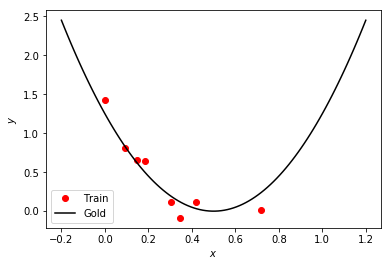

In [2]:
# parameters
n_instances = 8
sigma = 0.1 # keep this small: don't want too much noise

# generate data matrix with rows as instances
X = np.random.uniform(size=(n_instances,1))

# generate the target response values using the quadratic function
# and additive noise
Y = np.random.normal(loc=5*(X - 0.5)**2, scale=sigma, size=(n_instances,1)).ravel()

# plot the training data
plt.plot(X, Y, 'ro', label='Train')

# and plot the true function (without noise)
X_test = np.linspace(-0.2, 1.2, 100)
X_test = X_test[:,np.newaxis]
Y_test_gold = 5*(X_test - 0.5)**2 
plt.plot(X_test, Y_test_gold, 'k', label='Gold')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#### Polynomial basis functions
Since the relationship between $y$ and $x$ is non-linear, we'll apply polynomial basis expansion to degree $d$.
Specifically, we replace the original data matrix $\mathbf{X}$ by the transformed matrix below:
$$
\mathbf{\Phi} = \begin{bmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^d \\
    1 & x_2 & x_2^2 & \ldots & x_2^d \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^d \\
\end{bmatrix}
$$
Note that we're including a column of ones to account for the bias term.

The function below is a wrapper around `sklearn.preprocessing.PolynomialFeatures`, which implements the above transformation on a train/test set.

In [3]:
def polynomial_features(X_train, X_test, degree, include_bias=True):
    """
    Augments data matrices X_train and X_test with polynomial features
    """
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
    
    Phi_train = poly.fit_transform(X_train)
    Phi_test = poly.fit_transform(X_test)
    
    return Phi_train, Phi_test
    
Phi, Phi_test = polynomial_features(X, X_test, 9)

**Discussion**: How does this basis trick relate to kernel methods?

### 2. Bayesian regression with known variance

In this section, we're going to implement the Bayesian regression model described in lectures.

Let's being with a quick recap. The model assumes the data is generated according to a Normal distribution, where the mean is a linear function of the input vector and the variance $\sigma^2$ is **assumed known**.
The prior over the weight vector $\ws$ is also Normal—by setting the mean to zero and choosing a small $\gamma^2$, weights with large magnitude are penalised.
$$
\begin{align*}
\ws | \gamma &\sim \mathrm{Normal}\!\left[\mathbf{0}, \gamma^2 \mathbf{I}_m\right] & \mbox{Prior} \\
y | \mathbf{x}, \mathbf{w}, \sigma &\sim \mathrm{Normal}\!\left[\xs^\intercal \ws, \sigma^2\right] & \mbox{Likelihood}
\end{align*}
$$ 

Given this formulation, the next step is to solve for the posterior over $\ws$
$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma, \gamma) = \frac{p(\ys | \Xs, \ws, \sigma) p(\ws | \gamma)}{p(\ys | \Xs, \sigma)}
\end{align*}
$$
where $\Xs \in \mathbb{R}^{n \times m}$ is the feature matrix and $\ys \in \mathbb{R}^{n}$ is the vector of target values for each instance.

In lectures, we derived the following solution:
$$
\ws | \Xs, \ys, \sigma, \gamma \sim  \textrm{Normal}(\ws_N, \mathbf{V}_N)
$$
where $\Vs_N = \sigma^2 \left( \Xs^\intercal \Xs + \frac{\sigma^2}{\gamma^2} \Is_m \right)^{-1}$ and $\ws_N = \frac{1}{\sigma^2} \Vs_N \Xs^\intercal \ys$.

#### Computing the posterior parameters
Complete the function below to compute the posterior mean $\mathbf{w}_N$ and covariance matrix $\mathbf{V}_N$ for the weights based on the expression above.

In [4]:
def compute_posterior_params(X, Y, sigma, gamma):
    """
    Compute the parameters (mean and covariance) for the posterior over the weights
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    sigma : float
        positive scale parameter for y
    gamma : float
        positive scale parameter for w_i
    
    Returns
    =======
    The following items in a tuple:
    w_N : numpy array, shape: (n_features,)
        mean parameter
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    """
    V_N = sigma**2 * np.linalg.inv(X.T @ X + (sigma/gamma)**2 * np.identity(X.shape[1])) # fill in
    w_N = np.ravel(1/sigma**2 * V_N @ X.T @ Y) # fill in
    
    return w_N, V_N

gamma = 10 # larger implies more permissive, i.e. a more diffuse prior
w_N, V_N = compute_posterior_params(Phi, Y, sigma, gamma)

Let's plot the prior and posterior over $\mathbf{w}$ to see how they differ. 
Since $\mathbf{w}$ is $d+1$-dimensional, we can only visualise the posterior over a couple of the weights.
Here we look at $p(w_1, w_2|\mathbf{X}, \mathbf{y}, \sigma, \gamma)$.

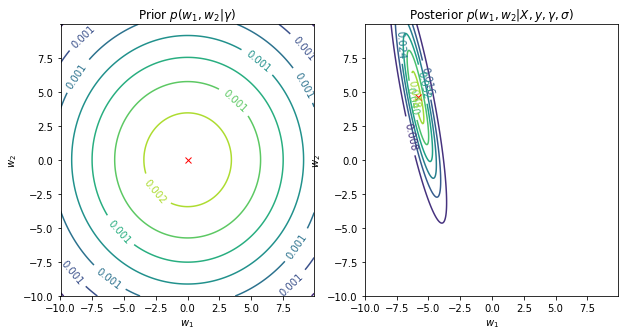

In [5]:
# set up a 2d plot mesh
w1, w2 = np.mgrid[-10:10:.05, -10:10:.05]
grid = np.c_[w1.ravel(), w2.ravel()]

fig = plt.figure(figsize=(10,5))
# plot a bivariate normal for the prior
ax = fig.add_subplot(121)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=np.zeros(2), cov=gamma**2 * np.identity(2))
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'rx') # add prior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Prior $p(w_1, w_2|\gamma)$')

# plot a bivariate normal for the posterior
ax = fig.add_subplot(122)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=w_N[1:3], cov=V_N[1:3,1:3])
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(w_N[1], w_N[2], 'rx') # add posterior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Posterior $p(w_1, w_2|X,y,\gamma,\sigma)$')
plt.show()

**Discussion question**: Can you explain why the prior and the posterior are so different? How is this related to the dataset? Why are the ellipses in the posterior not aligned to the axes? *You might want to change the parameter indices from 0,1 to other pairs to get a better idea of the full posterior.*

#### Bayesian inference
One way of doing inference for $y|\mathbf{x}$ is to draw a sample of weight vectors from the posterior (sampling from a Gaussian). 

Complete the function below to compute the predictive mean $E[y|\mathbf{x}] = \mathbf{w} \cdot \mathbf{x}$. 
Then run the code block below to plot 50 samples from the posterior.

In [6]:
def target_mean(X, w):
    """
    Compute the predictive mean for the target variable, given X and w
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    
    Returns
    =======
    Y_mean : numpy array, shape: (n_instances,)
        predictive mean for each instance in X
    """
    # your code here #
    return np.dot(X, w)

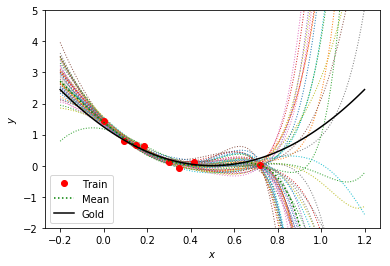

In [7]:
# generate some samples from the posterior
for i in range(50):
    # draw a weight vector
    w_i = np.random.multivariate_normal(w_N, V_N, 1).ravel()
    # plot the predictions for this weight vector
    p = plt.plot(X_test.ravel(), target_mean(Phi_test, w_i), ':', lw=1)

plt.plot(X, Y, 'ro', label='Train')
plt.plot(X_test, target_mean(Phi_test, w_N), 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

It's interesting to see what happens near the training data points, and away from them, in particular the edges of the plot.
We'll come back to this.

But there's a more elegant solution, as the predictive distribution can be found in closed form. Namely
$$
\begin{align*}
y_{*} | \xs_{*}, \ws_N, \Vs_N, \sigma &= \mathrm{Normal}\!\left[\xs_{*}'\ws_N, \sigma^2_N(\xs_{*})\right] \\
\sigma^2_N(\xs_{*}) & = \sigma^2 + \xs_{*}' \Vs_N \xs_{*}
\end{align*}
$$
Note that the predictive mean is a simple application of the posterior mean to the data point, but the predictive variance is a bit more complicated. 

Complete the function below to evaluate the predictive standard deviation, i.e. $\sigma_N(\mathbf{x}_{*})$. 
Then run the following code block to plot the results.

In [8]:
def target_std(X, V_N, sigma):
    """
    Compute the predictive standard deviation for the target variable, given X, V_N and sigma
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    
    Returns
    =======
    std : numpy array, shape: (n_instances,)
        predictive standard deviation for each instance in X
    """
    # your code here #
    return np.sqrt(sigma**2 + np.sum(X * (X @ V_N), axis=1))

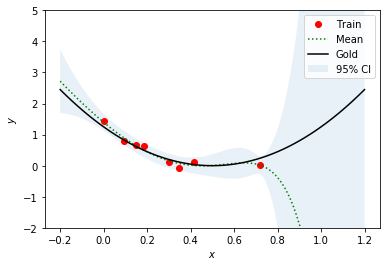

In [9]:
# compute the standard deviation using the formula above
Y_test_mean = target_mean(Phi_test, w_N)
Y_test_std = target_std(Phi_test, V_N, sigma)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

**Discussion**: How does the uncertainty plot compare to the samples above? How does the uncertainty change relative to the distance from training points? Can you explain why?

**Practical**: How does the setting of `gamma` affect the fit? How about the number of instances in the training set? Try some other values and see what happens.

**Discussion**: Is a 9th order polynomial a good choice for this problem? Based on the results above, would you recommend this model, or make a different choice?

### 3. Bayesian model selection
In this section, we'll revisit the assumption of having a 9th order polynomial. 
The evidence gives us a good way of evaluating the quality of fit.

Note that the evidence (a.k.a. marginal likelihood) is given by:
$$
p(\ys|\Xs, \sigma, \gamma) = \int p(\ys | \Xs, \sigma, \gamma, \ws) p(\ws) d \ws
$$
i.e. it's the likelihood function over the space of models for which the parameters $\ws$ have been marginalised out (see Sec 3.4 of Bishop).

In [10]:
def evaluate(w, X, Y, sigma, gamma):
    n_instances, n_features = X.shape
    alpha, beta = 1/float(gamma**2), 1/float(sigma**2)
    rss = np.sum((Y - np.dot(X, w))**2)
    wpen = np.dot(w, w)
    E = beta/2.0 * rss + alpha/2.0 * wpen
    A = alpha * np.identity(n_features) + beta * X.T @ X
    lE = n_features/2.0 * np.log(alpha) + n_instances/2.0 * np.log(beta) - E \
        - 0.5 * np.log(np.linalg.det(A)) - n_instances/2.0 * np.log(2.0 * np.pi)
    # return both the evidence, and the RSS term (the raw quality of fit)
    return {'logEvidence': lE, 'RSS': rss}

# what's the evidence for our 9th order model?
evaluate(w_N, Phi, Y, sigma, gamma)

{'logEvidence': -7.210639596237694, 'RSS': 0.07104621847390619}

So what happens if we use a lower order model, e.g., a 3rd order model?

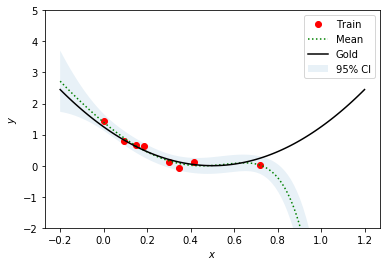

In [11]:
Phi_3, Phi_3_test = polynomial_features(X, X_test, 3)

w_N_3, V_N_3 = compute_posterior_params(Phi_3, Y, sigma, gamma)
Y_test = target_mean(Phi_3_test, w_N_3)
Y_test_std = target_std(Phi_3_test, V_N_3, sigma)
    
plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

**Discussion**: Does that look like a better fit to you? Consider both the interval $[0,1]$ near the training points, and those outside this range.

Let's see what the *evidence* says, and compare this to the above result:

In [12]:
evaluate(w_N_3, Phi_3, Y, sigma, gamma)

{'logEvidence': -6.643162549319177, 'RSS': 0.07888629421198828}

The RSS has barely changed, but the evidence is much higher. We can look at various model orders to see which has the best *evidence* to perform Bayesian model selection: 

In [13]:
d_range = np.arange(1, 11)
logEvidence = []
RSS = []
for d in d_range:
    Phi_d, Phi_d_test = polynomial_features(X, X_test, d)
    w_N_d, V_N_d = compute_posterior_params(Phi_d, Y, sigma, gamma)
    result = evaluate(w_N_d, Phi_d, Y, sigma, gamma)
    print('Degree {}. Log evidence {}. RSS {}.'.format(d, result['logEvidence'], result['RSS']))
    logEvidence.append(result['logEvidence'])
    RSS.append(result['RSS'])

Degree 1. Log evidence -29.39686607350171. RSS 0.6141638621964031.
Degree 2. Log evidence -5.7484162006696975. RSS 0.08259643223393945.
Degree 3. Log evidence -6.643162549319177. RSS 0.07888629421198828.
Degree 4. Log evidence -6.984455678318657. RSS 0.07653415360637797.
Degree 5. Log evidence -7.122658176161361. RSS 0.07462253729433685.
Degree 6. Log evidence -7.178029861618275. RSS 0.0731302070733773.
Degree 7. Log evidence -7.199556191663704. RSS 0.0720936722245625.
Degree 8. Log evidence -7.207664767336183. RSS 0.07143667429261112.
Degree 9. Log evidence -7.210639596237694. RSS 0.07104621847390619.
Degree 10. Log evidence -7.211712595946835. RSS 0.07082434587879333.


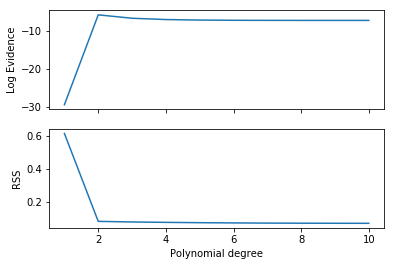

In [14]:
#plot the above log evidence values against the model order
ax1 = plt.subplot(211)
ax1.plot(d_range, logEvidence)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Log Evidence')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(d_range, RSS)
plt.xlabel('Polynomial degree')
plt.ylabel('RSS')
plt.show()

**Discussion**: So which model class will be chosen? Is this a reasonable situation? 

**Practical**: Rerun the code with a new random training set, or different values of *N*, such as 2 or 3 points or 20; the results may be different. Can you explain why the outcome might be different?

### 4. Bayesian regression with unknown variance

In real settings, the variance for $y$, $\sigma^2$ is unknown.
It's possible to account for this by putting the following prior on $\sigma^{2}$:
$$
\sigma^{-2} \sim \textrm{Gamma}(\alpha_1, \alpha_2)
$$
where $\alpha_1, \alpha_2 > 0$ are hyperparameters.

We can also put a prior over the variance for the weights, $\gamma^2$:
$$
\gamma^{-2} \sim \textrm{Gamma}(\lambda_1, \lambda_2)
$$
where $\lambda_1, \lambda_2 > 0$ are hyperparameters.

This model for regression (with the additional priors over $\gamma$ and $\sigma$) is implemented in `sklearn.linear_models.BayesianRidge`.

**Exercise**: Apply `BayesianRidge` to the training data (with the polynomial basis expansion) and compare the results to our simpler model.
What happens if the value of $\sigma$ used in our model deviates from the true value used to generate the data?
Is `BayesianRidge` more robust in this case?

In [15]:
reg = BayesianRidge(compute_score=True, fit_intercept=False).fit(Phi, Y)

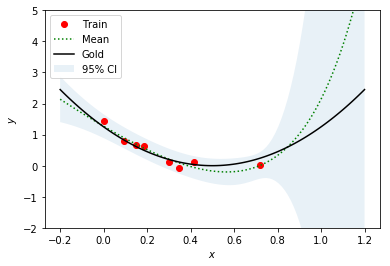

In [16]:
Y_test_mean, Y_test_std = reg.predict(Phi_test, return_std=True)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test, Y_test_mean, 'g:', label='Mean')
plt.plot(X_test, Y_test_gold, 'k', label='Gold')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()